TO DO:
Add 2nd pheromone matrix - Done
Create aggregate pheromone pull - Done
Change pheromone update to +=1/(f(S)) - Done (not using)
Global pareto front - Done
    Save all scores and graphs
    Pull pareto front each time

In [1]:
'''
IMPORTS
'''

%matplotlib inline

# Standard imports
import copy
import itertools

# Scientific computing imports
import numpy
import matplotlib.pyplot as plt
import networkx as nx
import pandas
import collections
from bisect import bisect
from networkx.algorithms.flow import edmonds_karp

import seaborn; seaborn.set()

# Import widget methods
from IPython.html.widgets import *

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
class Ant(object):
    """
    Ant class, which encapsulates the entire behavior of an ant.
    """
    def __init__(self,model,ant_id):
    
        # Set model link and ID
        self.model = model
        self.ant_id = ant_id
        
    def random_walk(self,source,sink):
        #Random Walk
        #initialize method
        self.source=source
        self.sink=sink
        self.g=nx.DiGraph()
        
        #initialize start of random walk
        self.last_nodes=self.source

        #Create path for an ant
        terminate=0
        while not terminate:
            terminate=1
            for i in xrange(len(self.last_nodes)):
                '''
                Ant step is encompassed below
                '''
                #track next nodes
                self.last_nodes_next=[]
                #get neighbors
                self.base_node=self.last_nodes[i]
                #self.base_node=self.last_nodes.pop()
                self.p_neighbors=self.get_neighbors(self.base_node)
                
                #get pheromone of each edge to neighbor
                self.edge_pheromone_list=[]
                for self.potential_node in self.p_neighbors:
                    self.edge_pheromone_list.append(self.get_pheromone_edge((self.base_node,self.potential_node)))
                
                #get next node
                self.next_node=self.p_neighbors[self.make_decision(self.edge_pheromone_list)]
                self.last_nodes_next.append(self.next_node)
                
                #add edge
                self.g.add_edge(self.base_node,self.next_node)
                #print(self.g.nodes())
                
                #get capacity pheromones
                self.capacity_pheromone_list=self.get_pheromone_capacity((self.base_node,self.next_node))
                
                #decide capacity
                self.capacity_to_add=self.model.capacities[self.make_decision(self.capacity_pheromone_list)]
                
                #add capacity
                self.g[self.base_node][self.next_node]['capacity']=self.capacity_to_add
                
                #Check termination criteria - are all sinks in the graph
                for sink_node in self.sink:
                    if sink_node not in self.g:
                        terminate=0
                        
            self.last_nodes=self.last_nodes_next   

        return (self.g)
    
    def get_neighbors(self,node):
        """
        Return neighbors, calling through model.
        """
        return self.model.get_ant_neighbors(node)
    
    def make_decision(self,pheromone_list):
        """
        Return decision index, based on pheromone list.
        """
        #convert pheromones to percentage
        self.percent_list = [float(i)/sum(pheromone_list) for i in pheromone_list]   
        self.cumulative_percent=numpy.cumsum(self.percent_list)

        #Choose decision index
        self.select_index=bisect(self.cumulative_percent,numpy.random.uniform(0,1,1))
  
        return self.select_index
    
    
    #def get_pheromone_node(self,node):
        """
        Return node pheromone, calling through model.
        """    
    
    
    def get_pheromone_edge(self,edge):
        """
        Return edge pheromone, calling through model.
        """
        return self.model.get_edge_pheromone(edge,self.ant_id)

    def get_pheromone_capacity(self,edge):
        """
        Return edge pheromone, calling through model.
        """
        return self.model.get_capacity_pheromone(edge,self.ant_id)
    

    def __repr__(self):
        '''
        Return string representation.
        '''
        skip_none = True
        repr_string = type(self).__name__ + " ["
        except_list = "model"

        elements = [e for e in dir(self) if str(e) not in except_list]
        for e in elements:
            # Make sure we only display "public" fields; skip anything private (_*), that is a method/function, or that is a module.
            if not e.startswith("_") and eval('type(self.{0}).__name__'.format(e)) not in ['DataFrame', 'function', 'method', 'builtin_function_or_method', 'module', 'instancemethod']:
                    value = eval("self." + e)
                    if value != None and skip_none == True:
                        repr_string += "{0}={1}, ".format(e, value)

        # Clean up trailing space and comma.
        return repr_string.strip(" ").strip(",") + "]"

    

In [9]:
class Space(object):
    """
    Space class, which encapsulates the entire behavior of a single "run" ACO.
    """
    def __init__(self, size,num_ants=1,source=[[(0,0)],[10]],sink=[[(2,2)],[5]],dissipation=.2,initial_pheromone=.1,capacities=[1,5,10]):
        """
        Class constructor.
        """
        # Set our model parameters
        self.size = size
        self.sink = sink[0]
        self.sink_magnitude = sink[1]
        self.source=source[0]
        self.source_magnitude = source[1]        
        self.num_ants=num_ants
        self.dissipation=dissipation
        self.initial_pheromone=initial_pheromone
        self.capacities=capacities
        
        # Set our state variables
        self.t = 0
        self.ants = []
        self.ant_graphs=[]
        #self.global_scores=[]

        
        # Call our setup methods to initialize space, people, and institution.
        self.setup_space()
        self.setup_ants()
        

    def setup_space(self):
        """
        Method to setup our space.
        """
        # Initialize a space with a grid network
        self.g = nx.grid_graph(dim=self.size)
        self.g=self.g.to_directed()
        
        #Set Pheromones
        print('Setting up network')
        for e in self.g.edges_iter():
            self.g.add_edge(e[0],e[1],capacity=0)
            self.g.add_edge(e[0],e[1],edge_pheromone=[self.initial_pheromone]*2)
            self.g.add_edge(e[0],e[1],capacity_pheromone=[[self.initial_pheromone]*len(self.capacities)]*2)

        self.g_layout = nx.spectral_layout(self.g)
 
        
    def setup_ants(self):
        """
        Method to setup our space.
        """       
        # First, begin by creating all ants.
        for i in xrange(self.num_ants):
            self.ants.append(Ant(model=self,ant_id=i))
        print self.ants
        
    def get_edge_pheromone(self,edge,ant_id):
        """
        Get edge decision pheromone for ant call
        """        
        ant_weight=float(ant_id-1)/(self.num_ants-1)
        pheromone_1=self.g[edge[0]][edge[1]]['edge_pheromone'][0]
        pheromone_2=self.g[edge[0]][edge[1]]['edge_pheromone'][1]
                
        return (pheromone_1**ant_weight)*(pheromone_2**(1-ant_weight))
    
    def get_capacity_pheromone(self,edge,ant_id):
        """
        Get edge decision pheromone for ant call
        """  
        ant_weight=float(ant_id-1)/(self.num_ants-1)
        pheromone_1=self.g[edge[0]][edge[1]]['capacity_pheromone'][0]
        pheromone_2=self.g[edge[0]][edge[1]]['capacity_pheromone'][1]
        
        weighted_pheromone_1=[i**ant_weight for i in pheromone_1]
        weighted_pheromone_2=[i**(1-ant_weight) for i in pheromone_2]
        composite_pheromone=[weighted_pheromone_1[i]*weighted_pheromone_2[i] for i in xrange(len(weighted_pheromone_1))]

        
        return composite_pheromone
        
        
    def get_ant_neighbors(self,node):
        """
        Get node neighbors for ant call
        """
        return self.g.neighbors(node)
            
    def get_path(self, ant_id):
        """
        Get the path of an ant based on their ID.
        """
        return self.ants[ant_id].random_walk(self.source,self.sink)
    
    def evaluate_graph(self, ant_graph):
        """
        Score graphs based on criteria.
        """
        #Score 1 - Length
        length_score=ant_graph.number_of_edges()
        
        #Score 2 - Flow
        #add aggregate sink
        flow_graph=ant_graph.copy()
        for i in xrange(len(self.sink)):
            flow_graph.add_edge(self.sink[i],'sink',capacity=self.sink_magnitude[i])
        
        #add aggregate source
        for i in xrange(len(self.source)):
            flow_graph.add_edge('source',self.source[i],capacity=self.source_magnitude[i])
        
        flow_value, flow_dict = nx.maximum_flow(flow_graph, 'source', 'sink')
        
        #flow is judged by the amount of flow that gets to the aggregate sink based on the total sink magnitude 
        flow_score=float(flow_value)/sum(self.sink_magnitude)       
        return (flow_score,length_score)
    
    def dominates(self, point_1, point_2, equality_sequence):
        '''
        Calculates if a point is dominated by another point, used in simple_cull_front
        equality_sequence:= 1 is '>=',0 is '<='
        '''
        score=0
        for i in range(len(point_1)):
            if equality_sequence[i]==1 and point_1[i]>=point_2[i]:
                score+=1
            elif equality_sequence[i]==0 and point_1[i]<=point_2[i]:
                score+=1
        dom=score==len(point_1)    
        return dom    
   
    def simple_cull_front(self, inputPoints, dominates, equality_sequence):
        '''
        Basic algorithm to find the pareto front of a set of points
        min or max is determined based on equality_sequence:= 0 is min, 1 is max
        '''
        paretoPoints = set()
        candidateRowNr = 0
        dominatedPoints = set()
        while True:
            candidateRow = inputPoints[candidateRowNr]
            inputPoints.remove(candidateRow)
            rowNr = 0
            nonDominated = True
            while len(inputPoints) != 0 and rowNr < len(inputPoints):
                row = inputPoints[rowNr]
                if self.dominates(candidateRow, row,equality_sequence):
                    # If it is worse on all features remove the row from the array
                    inputPoints.remove(row)
                    dominatedPoints.add(tuple(row))
                elif self.dominates(row, candidateRow, equality_sequence):
                    nonDominated = False
                    dominatedPoints.add(tuple(candidateRow))
                    rowNr += 1
                else:
                    rowNr += 1

            if nonDominated:
                # add the non-dominated point to the Pareto frontier
                paretoPoints.add(tuple(candidateRow))

            if len(inputPoints) == 0:
                break
        return paretoPoints, dominatedPoints

    
    def ant_ranking(self, ant_graphs):
        """
        Find best Ants based on scores from evaluate_graph.
        """
        score_list=[]
        [score_list.append(graph[1]) for graph in ant_graphs]
        #self.global_scores.extend(score_list)
        cull_scores=score_list[:]
        #print cull_scores,'cull_scores'
        #print self.global_scores,'before'
        equality_sequence=[1,0] #[>=,<=]
        paretoPoints, dominatedPoints=self.simple_cull_front(cull_scores,self.dominates,equality_sequence)
        paretoPoints=list(paretoPoints)
        #print 'pareto front',paretoPoints
        #print self.global_scores,'after'
        #get the best ants based on pareto front
        best_ants_index=[]
        
        #match the score_list indices to the pareto front values
        for i in xrange(len(score_list)):
            if score_list[i] in paretoPoints:
                best_ants_index.append(i)
                print 'pareto score @',i,':',score_list[i]
                
        return best_ants_index, score_list
    
    
    def step(self):
        """
        Model step function.
        """
        #Ants make paths
        self.ant_graphs=[] #exclude for initialized in setup for global pareto front
        
        #Step for each ant
        for i in xrange(self.num_ants):
            self.ant_graph=self.get_path(i)
            
            #Evaluate Paths
            self.graph_score=self.evaluate_graph(self.ant_graph) 
            
            #List <graph,score>
            self.ant_graphs.append((self.ant_graph,self.graph_score))
            
        #Get best score
        self.score_list=[]
        self.opt_ant,self.score_list=self.ant_ranking(self.ant_graphs)
        
        #Update Institutions - Edges and capacities for this walk
        #Get pheromones
        self.edge_pheromone_dict=nx.get_edge_attributes(self.g,'edge_pheromone')
        self.capacity_pheromone_dict=nx.get_edge_attributes(self.g,'capacity_pheromone')
        
        #Reduce edge pheromones by input amount
        for key in self.edge_pheromone_dict:    
            self.edge_pheromone_dict[key][0]*=(1-self.dissipation)      
            self.edge_pheromone_dict[key][1]*=(1-self.dissipation)
        
        #for key in self.capacity_pheromone_dict: #Update capacities of all paths
            #for i in xrange(len(self.capacity_pheromone_dict[key][0])):
                #self.capacity_pheromone_dict[key][0][i]*=(1-self.dissipation)
                #self.capacity_pheromone_dict[key][1][i]*=(1-self.dissipation)
                
        #Increment through best paths to update
        for ph_index in xrange(2):
            for ant in self.opt_ant:
                for e in self.ant_graphs[ant][0].edges():
                    #increase the pheromone amount of edges traveled by best ants\
                    if ph_index == 0: #flow
                        pheromone_increment=self.score_list[ant][ph_index]
                    else:
                        pheromone_increment=1.0/self.score_list[ant][ph_index]
                        
                    self.edge_pheromone_dict[e][ph_index]+=pheromone_increment #1.0/(len(self.opt_ant)) #1/(self.score_list[ant][ph_index])

                    #get capacity chosen and update pheromones
                    self.capacity_chosen=self.ant_graphs[ant][0][e[0]][e[1]]['capacity']
                    self.capacity_index=self.capacities.index(self.capacity_chosen)
                    for i in xrange(len(self.capacity_pheromone_dict[e])):
                        self.capacity_pheromone_dict[e][ph_index][i]*=(1-self.dissipation) #Update capacities of only travelled paths
                        #add pheromone if one chosen
                        if i == self.capacity_index:
                            self.capacity_pheromone_dict[e][ph_index][i]+=pheromone_increment #1.0/(len(self.opt_ant)) #1/(self.score_list[ant][ph_index])                                   
           
        
        #Set new edge pheromones
        nx.set_edge_attributes(self.g, 'edge_pheromone', self.edge_pheromone_dict)
        
        #Set new capacity pheromones
        nx.set_edge_attributes(self.g, 'capacity_pheromone', self.capacity_pheromone_dict)
        

Setting up network
[Ant [ant_id=0], Ant [ant_id=1], Ant [ant_id=2], Ant [ant_id=3], Ant [ant_id=4], Ant [ant_id=5], Ant [ant_id=6], Ant [ant_id=7], Ant [ant_id=8], Ant [ant_id=9]]
1
pareto score @ 2 : (0.5, 6)
10
2
pareto score @ 5 : (0.5, 13)
pareto score @ 7 : (0.1, 4)
10
3
pareto score @ 0 : (0.5, 4)
10
4
pareto score @ 1 : (1.0, 4)
10
5
pareto score @ 3 : (1.0, 4)
10
6
pareto score @ 6 : (1.0, 4)
10
7
pareto score @ 5 : (0.5, 4)
pareto score @ 8 : (0.5, 4)
pareto score @ 9 : (0.5, 4)
10
8
pareto score @ 0 : (0.1, 4)
pareto score @ 6 : (1.0, 5)
10
9
pareto score @ 0 : (0.5, 4)
pareto score @ 1 : (0.5, 4)
pareto score @ 4 : (0.5, 4)
pareto score @ 7 : (1.0, 6)
pareto score @ 8 : (0.5, 4)
pareto score @ 9 : (1.0, 6)
10
10
pareto score @ 8 : (1.0, 4)
10
11
pareto score @ 7 : (1.0, 4)
10
12
pareto score @ 1 : (1.0, 4)
pareto score @ 2 : (1.0, 4)
pareto score @ 3 : (1.0, 4)
pareto score @ 6 : (1.0, 4)
pareto score @ 7 : (1.0, 4)
10
13
pareto score @ 0 : (1.0, 4)
pareto score @ 2 : (1.0, 

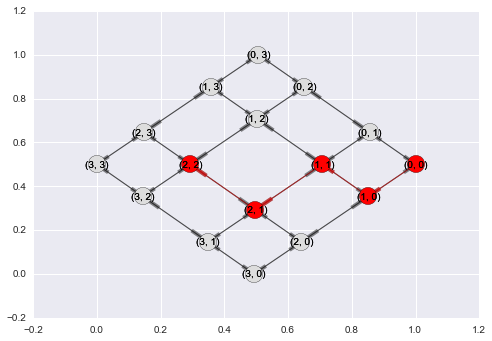

In [10]:
'''
Run Example
'''

space=Space(size=[4,4],num_ants=10,source=[[(0,0)],[10]],sink=[[(2,2)],[10]],initial_pheromone=1)
converged=0
i=1
while not converged:
    print(i)
    space.step()
    i+=1
    
    print len(space.score_list)
    
    if i>50:
        converged=1
        

print('Ant Path')

    

# Remove the nonpath from path nodes
nonpath_nodes = [node for node in space.g.nodes() if node not in space.ant_graphs[space.opt_ant[0]][0]]

# Now we can visualize the infected node's position
f = plt.figure()
nx.draw_networkx_nodes(space.ant_graphs[space.opt_ant[0]][0], space.g_layout,
                       node_color='red',edge_color='red')

nx.draw_networkx_nodes(space.g, space.g_layout,
                       nodelist=nonpath_nodes,
                       node_color='#dddddd')

nx.draw_networkx_edges(space.g, space.g_layout, 
                       width=1.0, 
                       alpha=0.5,
                       edge_color='#111111')

nx.draw_networkx_edges(space.ant_graphs[space.opt_ant[0]][0], space.g_layout,
                      edgelist=space.ant_graphs[space.opt_ant[0]][0].edges(),
                      width=1.0, 
                      alpha=0.5,
                      edge_color='red')


_ = nx.draw_networkx_labels(space.g, space.g_layout,
                        dict(zip(space.g.nodes(), space.g.nodes())),
                        font_size=10)
_ = nx.draw_networkx_labels(space.g, space.g_layout,
                        dict(zip(space.g.nodes(), space.g.nodes())),
                        font_size=10)

In [11]:
l1=[.1,.1]
l2=[.2,.2]
l1=[i**.3 for i in l1]
l2=[i**.7 for i in l2]
l=[l1[i]*l2[i] for i in xrange(len(l1))]

print l

[0.16245047927124714, 0.16245047927124714]


In [59]:
print space.score_list
print space.opt_ant

[(0.5, 4), (0.5, 4), (0.5, 4), (0.5, 4), (0.5, 4), (0.5, 4), (0.5, 4), (0.5, 4), (0.5, 4), (0.5, 4)]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [7]:
edge_pheromone_dict=nx.get_edge_attributes(space.g,'edge_pheromone')
print edge_pheromone_dict

{((2, 1), (3, 1)): [1.4272476927059634e-05, 1.4272476927059634e-05], ((1, 0), (2, 0)): [4.2845306712677094e-05, 2.6169526262882928e-05], ((0, 3), (1, 3)): [4.149506628073479e-05, 2.1078124265478418e-05], ((0, 2), (1, 2)): [1.4272476927059634e-05, 1.4272476927059634e-05], ((1, 1), (2, 1)): [1.9290144596729044e-05, 2.4307812266398446e-05], ((1, 1), (1, 2)): [49.988560593428446, 12.497161762258232], ((2, 0), (2, 1)): [4.2845306712677094e-05, 2.6169526262882928e-05], ((2, 0), (1, 0)): [2.5422849526324976e-05, 1.7458297669706875e-05], ((0, 1), (0, 0)): [4.693958415146978e-05, 1.8809575152672165e-05], ((2, 1), (2, 2)): [4.7862974382346486e-05, 3.6204861602221726e-05], ((0, 0), (1, 0)): [49.9885941839259, 12.497183694642906], ((1, 2), (2, 2)): [49.988560593428446, 12.497161762258232], ((2, 1), (2, 0)): [1.4272476927059634e-05, 1.4272476927059634e-05], ((0, 2), (0, 3)): [1.4272476927059634e-05, 1.4272476927059634e-05], ((3, 0), (3, 1)): [1.4272476927059634e-05, 1.4272476927059634e-05], ((1, 0)

In [8]:
space.ants

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:119: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


[Ant [ant_id=0, base_node=(1, 2), capacity_pheromone_list=[2.0084942212519752e-76, 2.4004577239786358e-76, 1.0], capacity_to_add=10, cumulative_percent=[  2.00849422e-76   4.40895195e-76   1.00000000e+00], edge_pheromone_list=[2.4437514300706894e-05, 1.784059615882453e-05, 1.784059615882453e-05, 10.712511031270994], g=, last_nodes=[(2, 2)], last_nodes_next=[(2, 2)], next_node=(2, 2), p_neighbors=[(1, 3), (0, 2), (1, 1), (2, 2)], percent_list=[2.0084942212519752e-76, 2.4004577239786358e-76, 1.0], potential_node=(2, 2), select_index=2, sink=[(2, 2)], source=[(0, 0)]],
 Ant [ant_id=1, base_node=(1, 2), capacity_pheromone_list=[2.0084942212519945e-76, 2.400457723978659e-76, 1.0], capacity_to_add=10, cumulative_percent=[  2.00849422e-76   4.40895195e-76   1.00000000e+00], edge_pheromone_list=[2.634765533184802e-05, 1.784059615882454e-05, 1.784059615882454e-05, 12.49645220282279], g=, last_nodes=[(2, 2)], last_nodes_next=[(2, 2)], next_node=(2, 2), p_neighbors=[(1, 3), (0, 2), (1, 1), (2, 2)